In [1]:
import pandas as pd
import os


print(os.getcwd())

truth_df = pd.read_csv( r'..\..\..\Data\ProcessedData\truth_cleand.csv')
print(truth_df.shape)
truth_df.head()

d:\Users\johan\OneDrive\Desktop\TrueGraphDynamics\Preperation\Enrichment\Truthfullnes
(656365, 14)


,id,timestamp,author,like_count,retruth_count,reply_count,text,hate_pred,hate_prob,sentiment_id,sentiment_conf,sentiment,statement_flag,statement_probability
0,703265,13,2247,0,0,0,q+ be ready anons - public awakening coming - ...,0,0.005426,1,0.851504,neutral,0,0.010807
1,807614,6,20054,0,0,0,enough is enough! retruth,0,0.001936,1,0.489587,neutral,0,0.029001
2,807619,7,20054,0,0,0,@user,0,0.001936,1,0.681377,neutral,0,0.037486
3,807621,6,20054,0,0,0,joe biden wants this video removed from the in...,0,0.015105,0,0.817848,negative,1,0.519844
4,807622,6,20054,0,0,0,<emoji: dart><emoji: 100><emoji: us>,0,0.003288,1,0.861522,neutral,0,0.011909


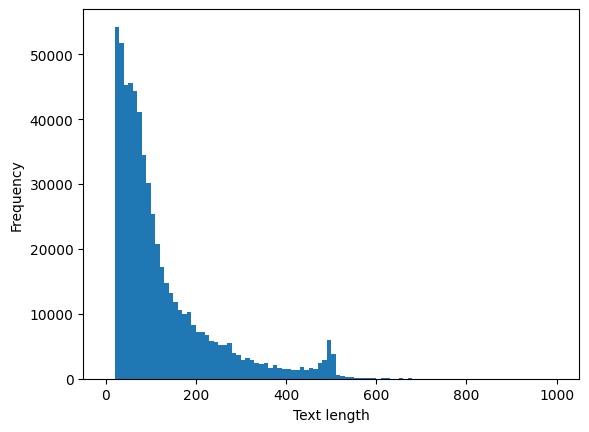

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

def clean_text(t):
    if pd.isna(t):
        return ""
    t = str(t).lower()
    t = re.sub(r"http\S+", "", t)       # remove URLs
    t = re.sub(r"@\w+", "@user", t)     # normalize mentions
    t = re.sub(r"\s+", " ", t).strip() # normalize whitespace
    return t

# clean text
truth_df['text'] = truth_df['text'].apply(clean_text)

# remove rows where text length < 20
truth_df = truth_df[truth_df['text'].str.len() >= 20]

# compute text lengths
text_lengths = truth_df['text'].str.len()

# histogram with bin width = 10
bins = np.arange(0, text_lengths.max() + 10, 10)

plt.hist(text_lengths, bins=bins)
plt.xlabel('Text length')
plt.ylabel('Frequency')
plt.show()

In [3]:
weak_labels = pd.read_csv(r'..\..\..\Data\ProcessedData\truth_labels_prefilterd_gpt5.csv')
df_joined = pd.merge(truth_df, weak_labels, on='id', how='inner')
print(df_joined)
df_joined.head()

           id  timestamp  author  like_count  retruth_count  reply_count  \
0      807621          6   20054           0              0            0   
1      703306         24   11225          12              4            6   
2      703308         24   11225          86             54           11   
3      703394         23   11225          16              0            0   
4      703282         24   11225           8              2            1   
...       ...        ...     ...         ...            ...          ...   
25015  934271          4   21566           0              0            0   
25016  934269          4    1629         243            114            8   
25017  934277          4    1629         161             72            8   
25018  934275          4   21566           0              0            0   
25019  934280          4    1629         299            149            7   

                                                    text  hate_pred  \
0      joe biden

,id,timestamp,author,like_count,retruth_count,reply_count,text,hate_pred,hate_prob,sentiment_id,sentiment_conf,sentiment,statement_flag,statement_probability,Unnamed: 0,TRUE,FALSE,NO_STATEMENT,truth_label
0,807621,6,20054,0,0,0,joe biden wants this video removed from the in...,0,0.015105,0,0.817848,negative,1,0.519844,0,0.02,0.08,0.90,NO_STATEMENT
1,703306,24,11225,12,4,6,jesus act of mercy on him is not for me to arg...,0,0.001281,1,0.577395,neutral,1,0.843496,1,0.05,0.05,0.90,NO_STATEMENT
2,703308,24,11225,86,54,11,our government lied..they never reported any s...,0,0.024585,0,0.869792,negative,1,0.917135,2,0.05,0.60,0.35,FALSE
3,703394,23,11225,16,0,0,just like the windmills failed in texas snow s...,1,0.800656,0,0.942177,negative,1,0.724487,3,0.15,0.15,0.70,NO_STATEMENT
4,703282,24,11225,8,2,1,if god had not promised noah he would never de...,1,0.825542,0,0.430576,negative,1,0.695649,4,0.02,0.08,0.90,NO_STATEMENT


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModel,
    TrainingArguments,
    Trainer
)

# -----------------------------
# Config
# -----------------------------
MODEL_NAME = "microsoft/deberta-v3-large"
MAX_LEN = 512
OUTPUT_DIR = "./truthfulness_dual_head_deberta"

FALSE_WEIGHT = 3.0

# -----------------------------
# Load DataFrame
# -----------------------------
# REQUIRED COLUMNS: ["text", "truth_label"]

label_map = {
    "TRUE": (1, 1),
    "FALSE": (1, 0),
    "NO_STATEMENT": (0, -1)
}

df_joined[["is_statement", "is_true"]] = df_joined["truth_label"].apply(
    lambda x: pd.Series(label_map[x])
)

dataset = Dataset.from_pandas(
    df_joined[["text", "is_statement", "is_true"]]
)

# -----------------------------
# Tokenizer
# -----------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(example):
    return tokenizer(
        example["text"],
        truncation=True,
        max_length=MAX_LEN,
        padding="max_length"
    )

dataset = dataset.map(tokenize, batched=True)
dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "is_statement", "is_true"]
)

# -----------------------------
# Base model (fp16, GPU)
# -----------------------------
base_model = AutoModel.from_pretrained(
    MODEL_NAME,
)

# -----------------------------
# Dual-head model
# -----------------------------
class DualHeadModel(nn.Module):
    def __init__(self, base_model, hidden_size):
        super().__init__()
        self.base_model = base_model
        self.statement_head = nn.Linear(hidden_size, 1)
        self.truth_head = nn.Linear(hidden_size, 1)

        self.stmt_loss_fn = nn.BCEWithLogitsLoss(reduction="none")
        self.truth_loss_fn = nn.BCEWithLogitsLoss(reduction="none")

    def forward(
        self,
        input_ids,
        attention_mask,
        is_statement=None,
        is_true=None
    ):
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # DeBERTa uses CLS token at position 0
        cls = outputs.last_hidden_state[:, 0]

        stmt_logits = self.statement_head(cls).squeeze(-1)
        truth_logits = self.truth_head(cls).squeeze(-1)

        loss = None
        if is_statement is not None:
            is_statement = is_statement.float()

            stmt_loss = self.stmt_loss_fn(
                stmt_logits, is_statement
            ).mean()

            mask = is_statement == 1
            if mask.any():
                truth_targets = is_true[mask].float()
                truth_logits_masked = truth_logits[mask]

                weights = torch.where(
                    truth_targets == 0,
                    torch.tensor(FALSE_WEIGHT, device=truth_logits.device),
                    torch.tensor(1.0, device=truth_logits.device)
                )

                truth_loss_raw = self.truth_loss_fn(
                    truth_logits_masked, truth_targets
                )

                truth_loss = (truth_loss_raw * weights).mean()
            else:
                truth_loss = torch.tensor(
                    0.0, device=stmt_logits.device
                )

            loss = stmt_loss + truth_loss

        return {
            "loss": loss,
            "p_statement": torch.sigmoid(stmt_logits),
            "p_true": torch.sigmoid(truth_logits)
        }

model = DualHeadModel(
    base_model,
    base_model.config.hidden_size
)

# -----------------------------
# Training arguments
# -----------------------------
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=4,   # you can try 32
    gradient_accumulation_steps=4,
    num_train_epochs=4,
    learning_rate=2e-5,
    fp16=True,
    logging_steps=50,
    save_strategy="epoch",
    optim="adamw_torch",
    report_to="none"
)

# -----------------------------
# Trainer
# -----------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset
)

trainer.train()

# -----------------------------
# Save
# -----------------------------
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

print("Training complete.")


c:\Users\johan\.venv\Lib\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/25020 [00:00<?, ? examples/s]

Step,Training Loss


KeyboardInterrupt: 